In [419]:
import csv
import pandas as pd
import numpy as np
import math
from scipy.linalg import solve

In [621]:
# Q1
# get the data of the market index
mkt = pd.read_csv("/Users/a7/Desktop/FIN3080/project3/TRD_index.csv")
mkt = pd.DataFrame(mkt,columns=["Trddt","Retindex"])
mkt.columns = ["date","mkt"]
mkt

,date,mkt
0,2020-01-02,0.019294
1,2020-01-03,0.002681
2,2020-01-06,0.004462
3,2020-01-07,0.013117
4,2020-01-08,-0.012446
...,...,...
702,2022-11-25,-0.006995
703,2022-11-28,-0.005101
704,2022-11-29,0.021359
705,2022-11-30,0.001215


In [622]:
# get the data of BYD
df = pd.read_csv("/Users/a7/Desktop/FIN3080/project3/TRD_Dalyr.csv")
df = pd.DataFrame(df,columns=["Trddt","Clsprc","Dretwd"])
df.columns = ["date","close_prc","ret"]
df

,date,close_prc,ret
0,2020-12-01,176.81,0.027069
1,2020-12-02,169.75,-0.039930
2,2020-12-03,171.09,0.007894
3,2020-12-04,171.86,0.004501
4,2020-12-07,175.29,0.019958
...,...,...,...
482,2022-11-25,245.05,-0.017402
483,2022-11-28,245.11,0.000245
484,2022-11-29,248.30,0.013015
485,2022-11-30,259.52,0.045187


In [623]:
df = pd.merge(df,mkt,on='date',how='left')
df

,date,close_prc,ret,mkt
0,2020-12-01,176.81,0.027069,0.016388
1,2020-12-02,169.75,-0.039930,0.001603
2,2020-12-03,171.09,0.007894,0.000067
3,2020-12-04,171.86,0.004501,0.005030
4,2020-12-07,175.29,0.019958,-0.003005
...,...,...,...,...
482,2022-11-25,245.05,-0.017402,-0.006995
483,2022-11-28,245.11,0.000245,-0.005101
484,2022-11-29,248.30,0.013015,0.021359
485,2022-11-30,259.52,0.045187,0.001215


In [624]:
# get the data of risk-free rate
rf = pd.read_csv("/Users/a7/Desktop/FIN3080/project3/TRD_Nrrate.csv")
rf = pd.DataFrame(rf,columns=["Clsdt","Nrrdaydt"])
rf.columns = ["date","rf"]
df = pd.merge(df,rf,on='date',how='left')
df

,date,close_prc,ret,mkt,rf
0,2020-12-01,176.81,0.027069,0.016388,0.0041
1,2020-12-02,169.75,-0.039930,0.001603,0.0041
2,2020-12-03,171.09,0.007894,0.000067,0.0041
3,2020-12-04,171.86,0.004501,0.005030,0.0041
4,2020-12-07,175.29,0.019958,-0.003005,0.0041
...,...,...,...,...,...
482,2022-11-25,245.05,-0.017402,-0.006995,0.0041
483,2022-11-28,245.11,0.000245,-0.005101,0.0041
484,2022-11-29,248.30,0.013015,0.021359,0.0041
485,2022-11-30,259.52,0.045187,0.001215,0.0041


In [625]:
# subtract rf from return and market return
for var in ['ret','mkt']:
    df[var+'_rf']=df[var]-df['rf']
df = df.loc[df.date>'2021-10-17']
df = df.loc[df.date<"2022-11-19"]
df.tail()

,date,close_prc,ret,mkt,rf,ret_rf,mkt_rf
473,2022-11-14,263.79,-0.018638,-0.002553,0.0041,-0.022738,-0.006653
474,2022-11-15,267.00,0.012169,0.020526,0.0041,0.008069,0.016426
475,2022-11-16,261.08,-0.022172,-0.007847,0.0041,-0.026272,-0.011947
476,2022-11-17,257.00,-0.015627,0.000605,0.0041,-0.019727,-0.003495
477,2022-11-18,254.68,-0.009027,-0.004856,0.0041,-0.013127,-0.008956


In [626]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('seaborn')
mpl.rcParams['font.family']='serif'
%matplotlib inline

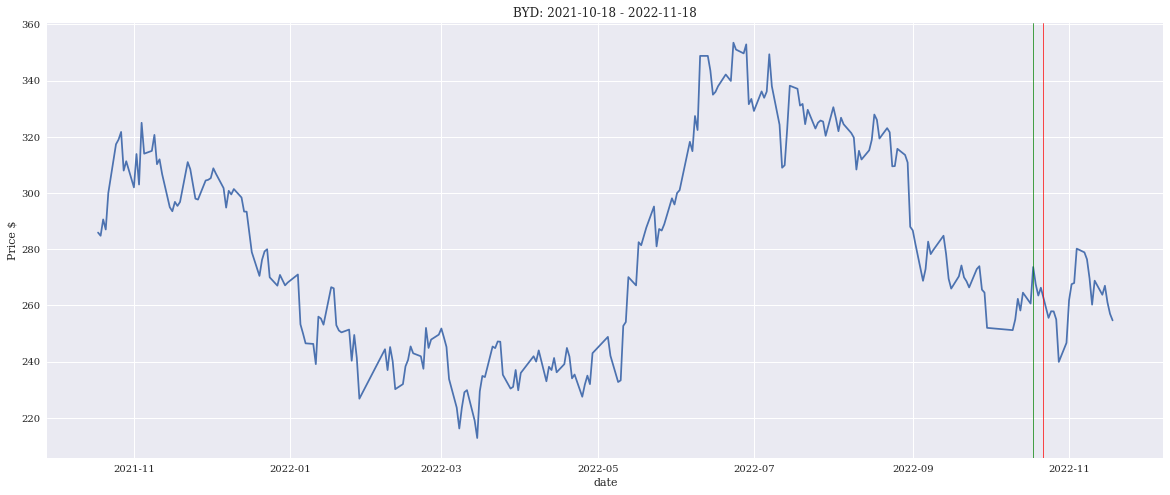

In [627]:
# plot the close price of BYD
df['date'] = pd.to_datetime(df['date'])
plt.figure(figsize=[20,8])
plt.plot(df.date,df.close_prc)
plt.axvline("2022-10-18",color="g",linewidth=0.7) # the split between estimation window and observation window
plt.axvline("2022-10-22",color="r",linewidth=0.7) #event date
plt.title('BYD: 2021-10-18 - 2022-11-18')
plt.xlabel('date')
plt.ylabel('Price \$')
plt.show()

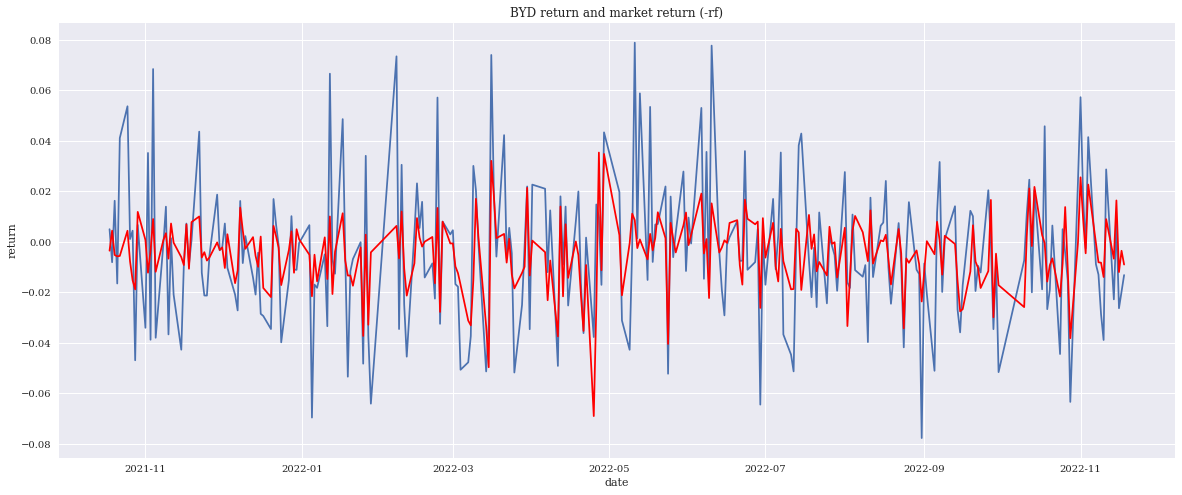

In [629]:
# to test the correlation between ret_rf and mkt_rf
plt.figure(figsize=[20,8])
plt.plot(df.date,df.ret_rf)
plt.plot(df.date,df.mkt_rf,color="r")
plt.title('BYD return and market return (-rf)')
plt.xlabel('date')
plt.ylabel('return')
plt.show()

In [633]:
# split the entire dataset into Estimation Window and Observation Window
# Estimation: 2021-10-18 ~ 2022-10-18 (1 year, about 252 trading days)
# Observation:2022-10-19 ~ 2022-11-18 (1 month, about 20 trading days)
# Event: 2022-10-22
df_est = df.loc[df['date'] < '2022-10-19']
df_obs = df.loc[df['date'] > '2022-10-18']

In [634]:
# (1) Means-adjusted returns model
bm1 = df_est['ret_rf'].mean() 
df_obs['AR1'] = df_obs['ret_rf'] - bm1
df_obs.head()

/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_6800/2681385123.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['AR1'] = df_obs['ret_rf'] - bm1


,date,close_prc,ret,mkt,rf,ret_rf,mkt_rf,AR1
455,2022-10-19,267.50,-0.022545,-0.011604,0.0041,-0.026645,-0.015704,-0.022788
456,2022-10-20,263.51,-0.014916,-0.005144,0.0041,-0.019016,-0.009244,-0.015159
457,2022-10-21,266.30,0.010588,-0.002413,0.0041,0.006488,-0.006513,0.010345
458,2022-10-24,255.57,-0.040293,-0.017563,0.0041,-0.044393,-0.021663,-0.040536
459,2022-10-25,257.91,0.009156,-0.004572,0.0041,0.005056,-0.008672,0.008913


In [632]:
bm1

-0.003856872950819671

In [635]:
# (2) Market-adjusted returns model
df_obs['AR2'] = df_obs['ret_rf'] - df_obs['mkt_rf']
df_obs.head()

/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_6800/2485956995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['AR2'] = df_obs['ret_rf'] - df_obs['mkt_rf']


,date,close_prc,ret,mkt,rf,ret_rf,mkt_rf,AR1,AR2
455,2022-10-19,267.50,-0.022545,-0.011604,0.0041,-0.026645,-0.015704,-0.022788,-0.010941
456,2022-10-20,263.51,-0.014916,-0.005144,0.0041,-0.019016,-0.009244,-0.015159,-0.009772
457,2022-10-21,266.30,0.010588,-0.002413,0.0041,0.006488,-0.006513,0.010345,0.013001
458,2022-10-24,255.57,-0.040293,-0.017563,0.0041,-0.044393,-0.021663,-0.040536,-0.022730
459,2022-10-25,257.91,0.009156,-0.004572,0.0041,0.005056,-0.008672,0.008913,0.013728


In [636]:
# (3) Risk-adjusted returns model:
import ols
model1 = ols.OLS(y = df_est['ret_rf'], x = df_est['mkt_rf'])
intercept = model1.alpha
intercept

0.0021718586319886242

In [637]:
gradient = model1.beta
gradient

1.2710578532022696

In [638]:
df_obs['pret'] = intercept + df_obs['mkt_rf'] * gradient
df_obs['AR3'] = df_obs['ret_rf'] - df_obs['pret']
df_obs.head()

/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_6800/1621623932.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['pret'] = intercept + df_obs['mkt_rf'] * gradient
/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_6800/1621623932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['AR3'] = df_obs['ret_rf'] - df_obs['pret']


,date,close_prc,ret,mkt,rf,ret_rf,mkt_rf,AR1,AR2,pret,AR3
455,2022-10-19,267.50,-0.022545,-0.011604,0.0041,-0.026645,-0.015704,-0.022788,-0.010941,-0.017789,-0.008856
456,2022-10-20,263.51,-0.014916,-0.005144,0.0041,-0.019016,-0.009244,-0.015159,-0.009772,-0.009578,-0.009438
457,2022-10-21,266.30,0.010588,-0.002413,0.0041,0.006488,-0.006513,0.010345,0.013001,-0.006107,0.012595
458,2022-10-24,255.57,-0.040293,-0.017563,0.0041,-0.044393,-0.021663,-0.040536,-0.022730,-0.025363,-0.019030
459,2022-10-25,257.91,0.009156,-0.004572,0.0041,0.005056,-0.008672,0.008913,0.013728,-0.008851,0.013907


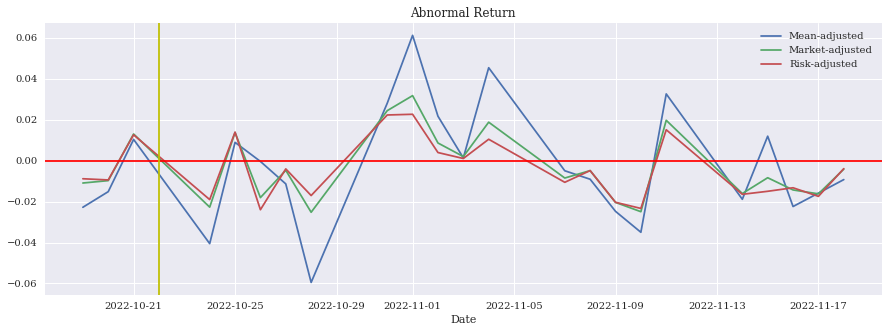

In [640]:
plt.figure(1,figsize=[15,5])
plt.plot(df_obs.date,df_obs.AR1,label="Mean-adjusted")
plt.plot(df_obs.date,df_obs.AR2,label="Market-adjusted")
plt.plot(df_obs.date,df_obs.AR3,label="Risk-adjusted")
plt.axhline(0,color="r")
plt.axvline("2022-10-22",color="y")
plt.title('Abnormal Return')
plt.xlabel('Date')
plt.legend()
plt.show()

In [641]:
df_obs['CAR1'] = df_obs['AR1'].cumsum()
df_obs['CAR2'] = df_obs['AR2'].cumsum()
df_obs['CAR3'] = df_obs['AR3'].cumsum()

/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_6800/1346841591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['CAR1'] = df_obs['AR1'].cumsum()
/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_6800/1346841591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['CAR2'] = df_obs['AR2'].cumsum()
/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_6800/1346841591.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

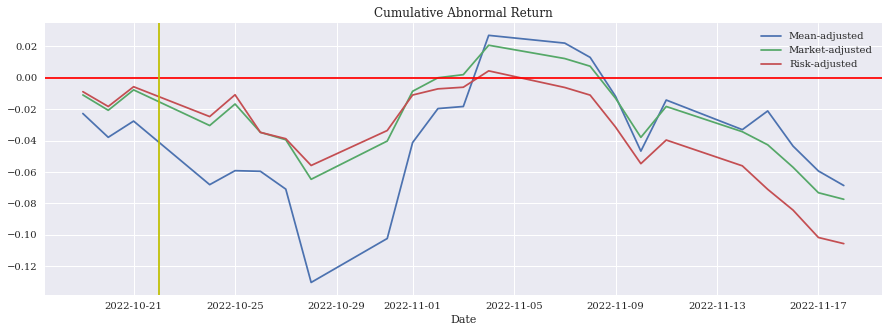

In [643]:
plt.figure(1,figsize=[15,5])
plt.plot(df_obs.date,df_obs.CAR1,label="Mean-adjusted")
plt.plot(df_obs.date,df_obs.CAR2,label="Market-adjusted")
plt.plot(df_obs.date,df_obs.CAR3,label="Risk-adjusted")
plt.axhline(0,color="r")
plt.axvline("2022-10-22",color="y")
plt.title('Cumulative Abnormal Return')
plt.xlabel('Date')
plt.legend()
plt.show()

In [498]:
# calculate the t-stat and p-value to test the significance
sigma = model1.std_err
sigma

0.021693613244887444

In [499]:
df_obs['T'] = df_obs['AR3']/sigma
df_obs.head()

/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_6800/3677961798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['T'] = df_obs['AR3']/sigma


,date,close_prc,ret,mkt,rf,ret_rf,mkt_rf,AR1,AR2,pret,AR3,CAR1,CAR2,CAR3,T
455,2022-10-19,267.50,-0.022545,-0.011604,0.0041,-0.026645,-0.015704,-0.022788,-0.010941,-0.017789,-0.008856,-0.022788,-0.010941,-0.008856,-0.408238
456,2022-10-20,263.51,-0.014916,-0.005144,0.0041,-0.019016,-0.009244,-0.015159,-0.009772,-0.009578,-0.009438,-0.037947,-0.020713,-0.018294,-0.435068
457,2022-10-21,266.30,0.010588,-0.002413,0.0041,0.006488,-0.006513,0.010345,0.013001,-0.006107,0.012595,-0.027602,-0.007712,-0.005700,0.580564
458,2022-10-24,255.57,-0.040293,-0.017563,0.0041,-0.044393,-0.021663,-0.040536,-0.022730,-0.025363,-0.019030,-0.068139,-0.030442,-0.024730,-0.877214
459,2022-10-25,257.91,0.009156,-0.004572,0.0041,0.005056,-0.008672,0.008913,0.013728,-0.008851,0.013907,-0.059226,-0.016714,-0.010823,0.641053


In [500]:
import scipy.stats as stats
df_obs['p-value'] = 2*(1 - stats.t.cdf(np.abs(df_obs['T']), df = len(df_est.index) - 2))
df_obs.head()

/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_6800/1857583269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['p-value'] = 2*(1 - stats.t.cdf(np.abs(df_obs['T']), df = len(df_est.index) - 2))


,date,close_prc,ret,mkt,rf,ret_rf,mkt_rf,AR1,AR2,pret,AR3,CAR1,CAR2,CAR3,T,p-value
455,2022-10-19,267.50,-0.022545,-0.011604,0.0041,-0.026645,-0.015704,-0.022788,-0.010941,-0.017789,-0.008856,-0.022788,-0.010941,-0.008856,-0.408238,0.683460
456,2022-10-20,263.51,-0.014916,-0.005144,0.0041,-0.019016,-0.009244,-0.015159,-0.009772,-0.009578,-0.009438,-0.037947,-0.020713,-0.018294,-0.435068,0.663901
457,2022-10-21,266.30,0.010588,-0.002413,0.0041,0.006488,-0.006513,0.010345,0.013001,-0.006107,0.012595,-0.027602,-0.007712,-0.005700,0.580564,0.562074
458,2022-10-24,255.57,-0.040293,-0.017563,0.0041,-0.044393,-0.021663,-0.040536,-0.022730,-0.025363,-0.019030,-0.068139,-0.030442,-0.024730,-0.877214,0.381241
459,2022-10-25,257.91,0.009156,-0.004572,0.0041,0.005056,-0.008672,0.008913,0.013728,-0.008851,0.013907,-0.059226,-0.016714,-0.010823,0.641053,0.522095


In [608]:
len(df_obs[df_obs['p-value'].abs()>1.96])

0

In [503]:
len(df_obs[df_obs['p-value']<0.05])

0

In [644]:
# Q2
event = pd.read_csv("/Users/a7/Desktop/FIN3080/project3/FIN_F_ForecFin.csv")
event = pd.DataFrame(event,columns=["StockCode","AccPeriod","RatNetProfPareComp_Hig"])
event.columns = ["stk","date","pred"]
event = event.dropna()
event = event.sort_values(['date','stk'],ascending=True)
event

,stk,date,pred
82,6,2012-03-31,61.00
166,9,2012-03-31,-66.12
226,11,2012-03-31,-98.00
254,12,2012-03-31,-71.00
649,34,2012-03-31,-116.26
...,...,...,...
78210,900940,2021-12-31,-62.07
78211,900940,2021-12-31,-190.37
78235,900943,2021-12-31,65.00
78340,900957,2021-12-31,26.00


In [645]:
# divide all events into 2 types:
event_pos = event.loc[event.pred>0]
event_neg = event.loc[event.pred<0]

In [646]:
# both the events happen every quarter
event_pos.date.unique()

array(['2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
       '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31',
       '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
       '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
       '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
       '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31',
       '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31',
       '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
       '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
       '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-31'],
      dtype=object)

In [647]:
event_neg.date.unique()

array(['2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
       '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31',
       '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
       '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
       '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
       '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31',
       '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31',
       '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
       '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
       '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-31'],
      dtype=object)

In [648]:
# get the data of all stocks
df_1 = pd.read_csv("/Users/a7/Desktop/FIN3080/project3/TRD_Dalyr1.csv")
df_2 = pd.read_csv("/Users/a7/Desktop/FIN3080/project3/TRD_Dalyr2.csv")
df_3 = pd.read_csv("/Users/a7/Desktop/FIN3080/project3/TRD_Dalyr3.csv")
df_4 = pd.read_csv("/Users/a7/Desktop/FIN3080/project3/TRD_Dalyr4.csv")
df_5 = pd.read_csv("/Users/a7/Desktop/FIN3080/project3/TRD_Dalyr5.csv")
df_6 = pd.read_csv("/Users/a7/Desktop/FIN3080/project3/TRD_Dalyr6.csv")
df_7 = pd.read_csv("/Users/a7/Desktop/FIN3080/project3/TRD_Dalyr7.csv")
df_8 = pd.read_csv("/Users/a7/Desktop/FIN3080/project3/TRD_Dalyr8.csv")
df_9 = pd.read_csv("/Users/a7/Desktop/FIN3080/project3/TRD_Dalyr9.csv")
df_10 = pd.read_csv("/Users/a7/Desktop/FIN3080/project3/TRD_Dalyr10.csv")
df_all = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10])
df_all = pd.DataFrame(df_all,columns=["Stkcd","Trddt","Clsprc","Dretwd"])
df_all.columns = ["stk","date","prc","ret"]
df_all = df_all.sort_values(['date','stk'],ascending=True)
df_all

,stk,date,prc,ret
0,1,2011-01-04,16.020,0.014566
236,2,2011-01-04,8.800,0.070560
478,4,2011-01-04,12.090,0.004153
720,5,2011-01-04,3.750,0.021798
797,6,2011-01-04,7.270,0.043042
...,...,...,...,...
574464,900948,2021-12-31,0.873,-0.007955
576539,900952,2021-12-31,0.248,0.000000
577756,900953,2021-12-31,0.339,0.018018
578972,900955,2021-12-31,0.119,0.017094


In [649]:
df_mkt = pd.read_csv("/Users/a7/Desktop/FIN3080/project3/TRD_index2.csv")
df_mkt = pd.DataFrame(df_mkt,columns=["Trddt","Retindex"])
df_mkt.columns = ["date","mkt"]
df_mkt

,date,mkt
0,2011-01-04,0.015872
1,2011-01-05,-0.004927
2,2011-01-06,-0.005072
3,2011-01-07,0.005171
4,2011-01-10,-0.016553
...,...,...
2892,2022-11-28,-0.007462
2893,2022-11-29,0.023127
2894,2022-11-30,0.000504
2895,2022-12-01,0.004486


In [650]:
df_all = pd.merge(df_all,df_mkt,on="date",how="left")
df_all = pd.merge(df_all,rf,on="date",how="left")
df_all

,stk,date,prc,ret,mkt,rf
0,1,2011-01-04,16.020,0.014566,0.015872,0.0074
1,2,2011-01-04,8.800,0.070560,0.015872,0.0074
2,4,2011-01-04,12.090,0.004153,0.015872,0.0074
3,5,2011-01-04,3.750,0.021798,0.015872,0.0074
4,6,2011-01-04,7.270,0.043042,0.015872,0.0074
...,...,...,...,...,...,...
8144679,900948,2021-12-31,0.873,-0.007955,0.005688,0.0041
8144680,900952,2021-12-31,0.248,0.000000,0.005688,0.0041
8144681,900953,2021-12-31,0.339,0.018018,0.005688,0.0041
8144682,900955,2021-12-31,0.119,0.017094,0.005688,0.0041


In [651]:
stk_all = event.stk.unique()
df_all = df_all[df_all.stk.isin(stk_all)]
df_all

,stk,date,prc,ret,mkt,rf
0,1,2011-01-04,16.020,0.014566,0.015872,0.0074
1,2,2011-01-04,8.800,0.070560,0.015872,0.0074
2,4,2011-01-04,12.090,0.004153,0.015872,0.0074
3,5,2011-01-04,3.750,0.021798,0.015872,0.0074
4,6,2011-01-04,7.270,0.043042,0.015872,0.0074
...,...,...,...,...,...,...
8144677,900946,2021-12-31,0.253,0.007968,0.005688,0.0041
8144679,900948,2021-12-31,0.873,-0.007955,0.005688,0.0041
8144680,900952,2021-12-31,0.248,0.000000,0.005688,0.0041
8144681,900953,2021-12-31,0.339,0.018018,0.005688,0.0041


In [652]:
for var in ['ret','mkt']:
    df_all[var+'_rf']=df_all[var]-df_all['rf']
df_all

/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_6800/571852040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all[var+'_rf']=df_all[var]-df_all['rf']


,stk,date,prc,ret,mkt,rf,ret_rf,mkt_rf
0,1,2011-01-04,16.020,0.014566,0.015872,0.0074,0.007166,0.008472
1,2,2011-01-04,8.800,0.070560,0.015872,0.0074,0.063160,0.008472
2,4,2011-01-04,12.090,0.004153,0.015872,0.0074,-0.003247,0.008472
3,5,2011-01-04,3.750,0.021798,0.015872,0.0074,0.014398,0.008472
4,6,2011-01-04,7.270,0.043042,0.015872,0.0074,0.035642,0.008472
...,...,...,...,...,...,...,...,...
8144677,900946,2021-12-31,0.253,0.007968,0.005688,0.0041,0.003868,0.001588
8144679,900948,2021-12-31,0.873,-0.007955,0.005688,0.0041,-0.012055,0.001588
8144680,900952,2021-12-31,0.248,0.000000,0.005688,0.0041,-0.004100,0.001588
8144681,900953,2021-12-31,0.339,0.018018,0.005688,0.0041,0.013918,0.001588


In [654]:
# find the estimation window and observation window for every event
date = event.date.unique()
date = pd.DataFrame(date)
date.columns = ["event"]
import datetime
date['event'] = pd.to_datetime(date['event'])
# the estimation period is the past 1 year, and the observation period is the following 1 month
date['est_end'] = date.event - datetime.timedelta(10)
date['est_begin'] = date.est_end - datetime.timedelta(365)
date['obs_end'] = date.est_end + datetime.timedelta(30)
# change into the string type for further use
date['event'] = date['event'].apply(lambda x:x.strftime('%Y-%m-%d'))
date['est_end'] = date['est_end'].apply(lambda x:x.strftime('%Y-%m-%d'))
date['est_begin'] = date['est_begin'].apply(lambda x:x.strftime('%Y-%m-%d'))
date['obs_end'] = date['obs_end'].apply(lambda x:x.strftime('%Y-%m-%d'))
date.head()

,event,est_end,est_begin,obs_end
0,2012-03-31,2012-03-21,2011-03-22,2012-04-20
1,2012-06-30,2012-06-20,2011-06-21,2012-07-20
2,2012-09-30,2012-09-20,2011-09-21,2012-10-20
3,2012-12-31,2012-12-21,2011-12-22,2013-01-20
4,2013-03-31,2013-03-21,2012-03-21,2013-04-20


In [667]:
# POSITIVE events:
AAR_pos=pd.DataFrame(range(20),columns=['index'])
for i in range(40):
    # get the 2 windows' begin and end date from the date table
    event_date = date.iloc[i,].event
    est_end = date.iloc[i,].est_end
    est_begin = date.iloc[i,].est_begin
    obs_end = date.iloc[i,].obs_end
    # find all the firms with positive prediction on that particular day
    stk = event_pos[event_pos.date==event_date].stk.unique()
    # get the information of these firms from the overall table
    total = df_all[df_all.stk.isin(stk)]
    # split the total data into estimation window and observation window
    est = total[total.date<=est_end]
    est = est[est.date>=est_begin]
    obs = total[total.date>est_end]
    obs = obs[obs.date<=obs_end]    
    # check the number of date for each stock in the estimation period (because we need to do regression)
    # if the number of date is smaller than 30, we discard it
    stk_num = pd.DataFrame(est.stk.value_counts()).reset_index()
    stk_num.columns = ["stk","count"]
    est = pd.merge(est,stk_num,on="stk",how="left")
    est = est[est['count'] > 30]
    # run regression for each stock
    est['alpha'] = est.groupby('stk').apply(lambda x: ols.OLS(y=x.ret_rf,x=x.mkt_rf).alpha)
    est['beta'] = est.groupby('stk').apply(lambda x: ols.OLS(y=x.ret_rf,x=x.mkt_rf).beta)
    est = pd.DataFrame(est,columns=["stk","alpha","beta"])
    # calculate the AR in observation period using the alpha and beta we got from regression
    obs = pd.merge(obs,est,on="stk",how="left")    
    obs['pred'] = obs['alpha'] + obs['mkt_rf'] * obs['beta']
    obs['AR'] = obs['ret_rf'] - obs['pred']
    aar = obs.groupby(['date']).AR.mean()
    aar = pd.DataFrame(aar)
    aar['index'] = range(len(aar))
    # AAR: average for all firms' AR on each day
    AAR_pos = pd.merge(AAR_pos,aar,on="index",how="left")

/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_6800/859956177.py:36: FutureWarning: Passing 'suffixes' which cause duplicate columns {'AR_x'} in the result is deprecated and will raise a MergeError in a future version.
  AAR_pos = pd.merge(AAR_pos,aar,on="index",how="left")


In [656]:
# NEGATIVE events:
AAR_neg=pd.DataFrame(range(20),columns=['index'])
for i in range(40):
    event_date = date.iloc[i,].event
    est_end = date.iloc[i,].est_end
    est_begin = date.iloc[i,].est_begin
    obs_end = date.iloc[i,].obs_end
    stk = event_neg[event_neg.date==event_date].stk.unique()
    total = df_all[df_all.stk.isin(stk)]
    est = total[total.date<=est_end]
    est = est[est.date>=est_begin]
    obs = total[total.date>est_end]
    obs = obs[obs.date<=obs_end]    
    stk_num = pd.DataFrame(est.stk.value_counts()).reset_index()
    stk_num.columns = ["stk","count"]
    est = pd.merge(est,stk_num,on="stk",how="left")
    est = est[est['count'] > 30]
    est['alpha'] = est.groupby('stk').apply(lambda x: ols.OLS(y=x.ret_rf,x=x.mkt_rf).alpha)
    est['beta'] = est.groupby('stk').apply(lambda x: ols.OLS(y=x.ret_rf,x=x.mkt_rf).beta)
    est = pd.DataFrame(est,columns=["stk","alpha","beta"])
    obs = pd.merge(obs,est,on="stk",how="left")    
    obs['pred'] = obs['alpha'] + obs['mkt_rf'] * obs['beta']
    obs['AR'] = obs['ret_rf'] - obs['pred']
    aar = obs.groupby(['date']).AR.mean()
    aar = pd.DataFrame(aar)
    aar['index'] = range(len(aar))
    AAR_neg = pd.merge(AAR_neg,aar,on="index",how="left")

/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_6800/3159923666.py:27: FutureWarning: Passing 'suffixes' which cause duplicate columns {'AR_x'} in the result is deprecated and will raise a MergeError in a future version.
  AAR_neg = pd.merge(AAR_neg,aar,on="index",how="left")


In [668]:
AAR_pos = AAR_pos.T
AAR_pos = pd.DataFrame(AAR_pos).reset_index()
AAR_pos = AAR_pos.drop(labels=0)
AAR_pos = AAR_pos.drop(labels="index",axis=1)
AAR_pos.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,0.002631,-0.004867,0.004477,0.002898,-0.015604,-0.002874,-0.009615,0.007646,0.010642,0.001507,0.001822,0.002474,-0.004633,0.002283,-0.001319,-0.001310,-0.002769,0.000493,-0.008429,NaN
2,0.002230,-0.005360,-0.000074,0.003914,-0.000563,-0.002980,0.014737,0.005851,-0.003478,-0.005075,0.004859,0.008440,-0.008636,0.000626,0.008775,-0.008994,-0.019440,-0.004624,0.003153,0.00123
3,-0.015072,-0.000469,-0.007248,-0.013636,-0.013953,-0.002089,0.006802,0.001665,0.006305,-0.007247,-0.004719,-0.000624,0.002215,-0.002363,-0.000348,-0.000540,NaN,NaN,NaN,NaN
4,0.005774,-0.010284,0.017052,-0.004352,-0.004549,-0.012377,-0.013503,0.009449,0.021222,0.001893,-0.000521,0.003986,-0.002339,0.011261,0.005235,0.003656,-0.004198,NaN,NaN,NaN
5,-0.000720,-0.000877,0.007572,-0.000454,0.003259,-0.001449,0.010628,-0.019892,-0.012926,0.019165,0.004064,-0.006860,-0.003063,0.000903,0.000233,0.005650,0.014135,0.003154,-0.002870,NaN


In [681]:
cum_pos = AAR_pos.sum()
cum_pos

0    -0.016694
1    -0.029688
2     0.069652
3    -0.088599
4    -0.161923
5    -0.081727
6     0.032319
7     0.007245
8    -0.000471
9    -0.103619
10   -0.077157
11   -0.026501
12   -0.033644
13    0.123927
14    0.059814
15    0.013183
16   -0.072291
17    0.057217
18    0.028996
19    0.044554
dtype: float64

In [671]:
AAR_neg = AAR_neg.T
AAR_neg = pd.DataFrame(AAR_neg).reset_index()
AAR_neg = AAR_neg.drop(labels=0)
AAR_neg = AAR_neg.drop(labels="index",axis=1)
AAR_neg.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,0.000106,-0.007550,-0.007885,-0.001280,-0.010555,-0.005017,-0.022568,0.006322,0.003570,-0.001864,-0.000358,0.003220,-0.002676,0.002661,-0.004214,-0.000383,-0.006120,0.001833,-0.007168,NaN
2,0.001768,-0.006411,0.000136,-0.003731,-0.002940,-0.009073,0.008255,0.000657,-0.002899,-0.012153,0.001274,0.001911,-0.006923,-0.001387,0.003269,-0.014105,-0.026290,-0.002537,-0.000519,0.003877
3,-0.015408,0.003341,-0.005611,-0.013686,-0.014268,-0.001436,0.009638,0.001782,0.016492,-0.007080,-0.008188,-0.017371,0.002089,0.002059,-0.001260,0.003255,NaN,NaN,NaN,NaN
4,0.001766,-0.016064,0.015985,-0.001810,-0.011164,-0.016823,-0.009627,0.008300,0.018128,0.003037,0.001237,0.005786,-0.009942,0.011229,0.010383,0.002029,-0.006667,NaN,NaN,NaN
5,-0.002873,0.000726,0.004641,0.002000,0.003199,-0.005390,0.002676,-0.011641,-0.012411,-0.000927,0.006461,-0.004573,-0.001133,-0.000631,-0.006833,0.002283,0.009428,0.002239,-0.008549,NaN


In [682]:
cum_neg = AAR_neg.sum()
cum_neg

0    -0.044880
1    -0.026556
2    -0.005732
3    -0.069725
4    -0.175800
5    -0.133468
6    -0.071532
7     0.015910
8    -0.012652
9    -0.190117
10   -0.103743
11   -0.144145
12   -0.095283
13    0.040467
14    0.015327
15   -0.054426
16   -0.184606
17    0.007543
18   -0.019681
19    0.039491
dtype: float64

In [683]:
pos = pd.DataFrame(cum_pos).reset_index()
neg = pd.DataFrame(cum_neg).reset_index()
caar = pd.merge(pos,neg,on="index",how="left")
caar.columns = ['date_index','pos_events','neg_events']
caar

,date_index,pos_events,neg_events
0,0,-0.016694,-0.044880
1,1,-0.029688,-0.026556
2,2,0.069652,-0.005732
3,3,-0.088599,-0.069725
4,4,-0.161923,-0.175800
5,5,-0.081727,-0.133468
6,6,0.032319,-0.071532
7,7,0.007245,0.015910
8,8,-0.000471,-0.012652
9,9,-0.103619,-0.190117


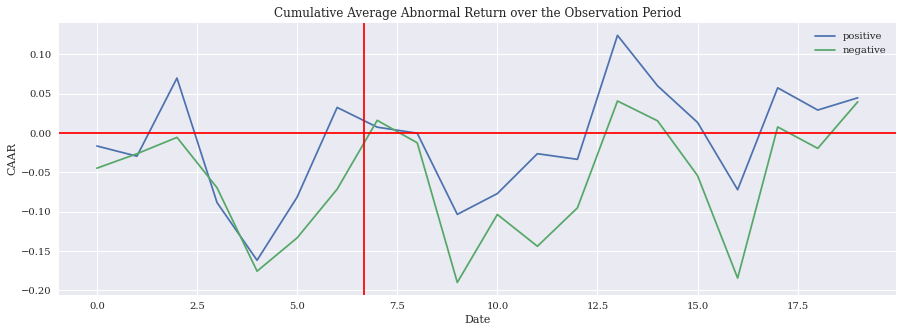

In [673]:
plt.figure(1,figsize=[15,5])
plt.plot(cum_pos,label="positive")
plt.plot(cum_neg,label="negative")
plt.axvline(20/3,color="r")
plt.axhline(0,color="r")
plt.title('Cumulative Average Abnormal Return over the Observation Period')
plt.ylabel('CAAR')
plt.xlabel('Date')
plt.legend()
plt.show()

In [674]:
cum_pos = pd.DataFrame(cum_pos).reset_index()
cum_neg = pd.DataFrame(cum_neg).reset_index()
long_short = pd.merge(cum_pos,cum_neg,on="index",how="left")
long_short.columns = ["index","pos","neg"]
long_short['diff'] = long_short['pos'] - long_short['neg']
long_short

,index,pos,neg,diff
0,0,-0.016694,-0.044880,0.028186
1,1,-0.029688,-0.026556,-0.003132
2,2,0.069652,-0.005732,0.075384
3,3,-0.088599,-0.069725,-0.018875
4,4,-0.161923,-0.175800,0.013878
5,5,-0.081727,-0.133468,0.051741
6,6,0.032319,-0.071532,0.103852
7,7,0.007245,0.015910,-0.008664
8,8,-0.000471,-0.012652,0.012181
9,9,-0.103619,-0.190117,0.086498


No handles with labels found to put in legend.


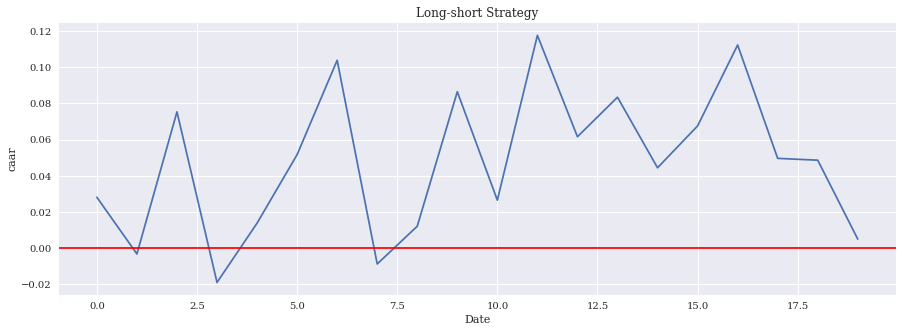

In [675]:
plt.figure(1,figsize=[15,5])
plt.plot(long_short['index'],long_short['diff'])
plt.axhline(0,color="r")
plt.title('Long-short Strategy')
plt.ylabel('caar')
plt.xlabel('Date')
plt.legend()
plt.show()